In [1]:
import numpy as np
import sys
import gsw
import xarray as xr
import numpy as np
from scipy import integrate
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v4'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [3]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['SSHDYN','OBPNOPAB','PHIHYD','RHOAnoma','SALT'],\
                                           years_to_load=range(2011,2017)).load() # if desired, add after 'SSH','NEW_VAR',... 'SSH','OBP',                                           
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  OBPNOPAB
loading files of  PHIHYD
loading files of  RHOAnoma
loading files of  SALT
loading files of  SSHDYN


In [5]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)

In [6]:
# load steric height and steric pressure already computed 
ds_den0 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_steric_2011_2017.nc'
ds_den = xr.open_dataset(ds_den0)

In [7]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
# XC distance from grid center point to center point 
# XG distance from grid egde (where u is defined) to grid edge (finite difference of values at XC will be placed here)
grid = Grid(ecco_monthly_ds, metrics=metrics)

In [8]:
tile_num=10
lon_range = [-99, -45]
lat_range = [15, 50]
# lon_range = [-39, 0]
# lat_range = [20, 60]
# -- pull out lats and lons
lons = ecco_monthly_ds.XC.sel(tile=tile_num)
lats = ecco_monthly_ds.YC.sel(tile=tile_num)
lons_g = ecco_monthly_ds.XG.sel(tile=tile_num)
lats_g = ecco_monthly_ds.YG.sel(tile=tile_num)

In [9]:
# bathymetry
dep = ecco_monthly_ds.Depth
dep = dep.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
testx = grid.diff(dep,axis='X')/(ecco_monthly_ds.dxG.data/1000)
testy = grid.diff(dep,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
H_x = grid.interp(testx,'X')
H_y = grid.interp(testy,'Y')
gradH_np = np.sqrt(H_x.isel(tile=tile_num).data**2 + H_y.isel(tile=tile_num).data**2)
gradH = xr.DataArray(
    data=gradH_np, dims=["j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
    ),
)

In [90]:
g = 9.81 
rho0 = 1035

# -- bring in fields and remove time mean and linear trend (and set land values to 0)
# -- SLA --  
ssh_anom = ecco_monthly_ds.SSHDYN-ecco_monthly_ds.SSHDYN.mean(dim='time')
p = ssh_anom.polyfit(dim='time', deg=1)
ssh_a_trend = xr.polyval(ssh_anom['time'], p.polyfit_coefficients)
ssh_a_detrend = ssh_anom - ssh_a_trend
s_press = rho0*g*(ssh_a_detrend)
s_press = s_press.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# -- OBP -- 
obp_anom = ecco_monthly_ds.OBPNOPAB-ecco_monthly_ds.OBPNOPAB.mean(dim='time')
p = obp_anom.polyfit(dim='time', deg=1)
obp_a_trend = xr.polyval(obp_anom['time'], p.polyfit_coefficients)
obp_a_detrend = obp_anom - obp_a_trend
obp = rho0*g*(obp_a_detrend)
obp = obp.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# -- Steric Height -- 
ster_a = 1*(ds_den.steric_p-ds_den.steric_p.mean(dim='time'))
p = ster_a.polyfit(dim='time', deg=1)
ster_a_trend = xr.polyval(ster_a['time'], p.polyfit_coefficients)
ster_a_detrend = ster_a - ster_a_trend
ster = ster_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

# -- density anomalies (my estimate) -- 
rho_a = ds_den.rho.isel(tile=tile_num) - ds_den.rho.isel(tile=tile_num).mean(dim='time')
p = rho_a.polyfit(dim='time', deg=1)
rho_a_trend = xr.polyval(rho_a['time'], p.polyfit_coefficients)
rho_a_detrend = rho_a - rho_a_trend
rho = rho_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

# -- density anomalies (RHOAnoma) -- 
rho_0 = ecco_monthly_ds.RHOAnoma.isel(tile=tile_num)
rho_0 = rho_0.where(ecco_monthly_ds.hFacC.isel(tile=tile_num) !=0, np.nan)
rho_a_2 = rho_0 - rho_0.mean(dim='time')
p_2 = rho_a_2.polyfit(dim='time', deg=1)
rho_a_2_trend = xr.polyval(rho_a_2['time'], p_2.polyfit_coefficients)
rho_a_2_detrend = rho_a_2 - rho_a_2_trend
rho_2 = rho_a_2_detrend

# -- PRESSURE 
p_hyd = rho0*ecco_monthly_ds.PHIHYD.isel(tile=tile_num) #p/rhoConst
p_hyd = p_hyd.where(ecco_monthly_ds.hFacC.isel(tile=tile_num) !=0, np.nan)
p_a = p_hyd - p_hyd.mean(dim='time')
p_p = p_a.polyfit(dim='time', deg=1)
p_a_trend = xr.polyval(p_a['time'], p_p.polyfit_coefficients)
p_a_detrend = p_a - p_a_trend
p_h = p_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

In [108]:
# -- derivatives 
# - sea surface height 
basex_eta = grid.diff(s_press,axis='X')/(ecco_monthly_ds.dxG.data/1000)
basey_eta = grid.diff(s_press,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
deta_dx = grid.interp(basex_eta,'X')
deta_dy = grid.interp(basey_eta,'Y')
# - ocean bottom pressure
basex = grid.diff(obp,axis='X')/(ecco_monthly_ds.dxG.data/1000)
basey = grid.diff(obp,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
dobp_dx = grid.interp(basex,'X')
dobp_dy = grid.interp(basey,'Y')
# - steric height
basex = grid.diff(ster,axis='X')/(ecco_monthly_ds.dxG.data/1000)
basey = grid.diff(ster,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
dster_dx = grid.interp(basex,'X')
dster_dy = grid.interp(basey,'Y')
# - density 
basex_rho = grid.diff(rho,axis='X')/(ecco_monthly_ds.dxG.isel(tile=tile_num).data/1000)
basey_rho = grid.diff(rho,axis='Y')/(ecco_monthly_ds.dyG.isel(tile=tile_num).data/1000)
drho_dx = grid.interp(basex_rho,'X')
drho_dy = grid.interp(basey_rho,'Y')
# - approx D (vertical integral of g*z*drho_dx,g*z*drho_dy)
layer_thickness = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF
zz = layer_thickness.Z
zz = zz.where(layer_thickness != 0, np.nan)
layer_thickness = layer_thickness.rename({'k': 'layer'})
# layer_thickness = layer_thickness.where(layer_thickness != 0, np.nan)
zz = zz.rename({'k': 'layer'})
# zz = -1*layer_thickness.cumsum(dim='layer')
H = (ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF).sum(dim='k')
H = H.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
a_D_x0 = (g*zz*drho_dx*layer_thickness).sum(dim='layer')
a_D_y0 = (g*zz*drho_dy*layer_thickness).sum(dim='layer')
a_D_x0 = a_D_x0.where(a_D_x0 !=0, np.nan)
a_D_y0 = a_D_y0.where(a_D_y0 !=0, np.nan)
a_D_x = (-1/H)*a_D_x0
a_D_y = (-1/H)*a_D_y0
# - alternate statement on bottom pressure gradient 
# E = (g*zz*rho*layer_thickness).sum(dim='layer')
# basex_E = grid.diff(E,axis='X')/(ecco_monthly_ds.dxG.isel(tile=tile_num).data/1000)
# basey_E = grid.diff(E,axis='Y')/(ecco_monthly_ds.dyG.isel(tile=tile_num).data/1000)
# dE_dx = grid.interp(basex_E,'X')
# dE_dy = grid.interp(basey_Y,'Y')
# dpb_dx = dE_dx.where(dE_dx !=0, np.nan)
# dpb_dy = dE_dy.where(dE_dx !=0, np.nan)

# - depth average horizontal pressure gradient 
layer_thickness = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF
# layer_thickness = layer_thickness.where(layer_thickness != 0, np.nan)
basex_p = grid.diff(p_h,axis='X')/(ecco_monthly_ds.dxG.isel(tile=tile_num).data/1000)
basey_p = grid.diff(p_h,axis='Y')/(ecco_monthly_ds.dyG.isel(tile=tile_num).data/1000)
dp_dx = grid.interp(basex_p,'X')
dp_dy = grid.interp(basey_p,'Y')
dahpg_x = (dp_dx*layer_thickness).sum(dim='k')
dahpg_y = (dp_dy*layer_thickness).sum(dim='k')
dahpg_x = dahpg_x.where(dahpg_x !=0, np.nan)
dahpg_y = dahpg_y.where(dahpg_y !=0, np.nan)
dahpg_x = (1/H)*dahpg_x
dahpg_y = (1/H)*dahpg_y

# - find bottom layer index
test = np.ceil(ecco_grid.hFacC.sum(dim='k')).isel(tile=tile_num) - 1 # remember index is off by one from layer numbers # np.floor(ecco_grid.hFacC.sum(dim='k')).isel(tile=tile_num)
# - bottom density*g*bathymetric gradient 
topox = (rho.isel(layer=test.astype(int)))*g*H_x.isel(tile=tile_num) # - rho.isel(layer=test.astype(int)).mean(dim='time')
topoy = (rho.isel(layer=test.astype(int)))*g*H_y.isel(tile=tile_num)
# topox = (rho_bot.max(dim=['layer']) - rho_bot.max(dim=['layer']).mean(dim='time'))*g*H_x.isel(tile=tile_num) 
# topoy = (rho_bot.max(dim=['layer']) - rho_bot.max(dim=['layer']).mean(dim='time'))*g*H_y.isel(tile=tile_num)

In [86]:
lon_test = 38
lat_test = 73  
# lon_test = 37 # 36,38
# lat_test = 71 # 70
layer_thickness = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF

print(p_h[0,:,lon_test,lat_test].data)
print(dp_dx[0,:,lon_test,lat_test].data)
print(layer_thickness[:,lon_test,lat_test].data)
dahpg_x[lon_test,lat_test,0].data

[ 209.43296201  320.08266222  423.0025659   508.46669843  573.82054364
  621.38182744  654.55706037  675.7178862   685.14501011  682.22208579
  671.81747299  662.25517893  656.36540957  652.14414257  646.98450798
  639.17276237  627.89083636  613.48723431  597.30218117  580.51440977
  563.22461021  544.53878672  523.48270511  500.18609068  475.33651669
  449.74174138  424.08489005  398.69946777  373.70771509  349.08857675
  324.81388751  300.86911838  276.98873664  252.52006777  226.45807273
  197.6039289   164.91834099  127.73364278   85.66056882   38.56870658
  -13.59874866  -70.85637553 -133.24176356           nan           nan
           nan           nan           nan           nan           nan]
[-0.0900525  -0.15282784 -0.20570382 -0.24106462 -0.26433731 -0.28218934
 -0.30016454 -0.32642616 -0.3687234  -0.41617985 -0.43898605 -0.43829393
 -0.43548616 -0.43608425 -0.44032131 -0.44576499 -0.45234851 -0.46059084
 -0.46826143 -0.46919741 -0.4583041  -0.43501311 -0.40171858 -0.359981

array(0.)

In [109]:
# variance metrics 
deta_dx2 = (deta_dx.isel(tile=tile_num)).var(dim='time')
deta_dy2 = (deta_dy.isel(tile=tile_num)).var(dim='time')
K_eta = np.sqrt(0.5*(deta_dx2 + deta_dy2))
dster_dx2 = (dster_dx.isel(tile=tile_num)).var(dim='time')
dster_dy2 = (dster_dy.isel(tile=tile_num)).var(dim='time')
K_ster = np.sqrt(0.5*(dster_dx2 + dster_dy2))
dobp_dx2 = (dobp_dx.isel(tile=tile_num)).var(dim='time')
dobp_dy2 = (dobp_dy.isel(tile=tile_num)).var(dim='time')
K_obp = np.sqrt(0.5*(dobp_dx2 + dobp_dy2))
dtopo_dx2 = (topox).var(dim='time')
dtopo_dy2 = (topoy).var(dim='time')
K_topo = np.sqrt(0.5*(dtopo_dx2 + dtopo_dy2))
dD_dx2 = (a_D_x).var(dim='time')
dD_dy2 = (a_D_y).var(dim='time')
K_D = np.sqrt(0.5*(dD_dx2 + dD_dy2))
dp_dx2 = (dahpg_x).var(dim='time')
dp_dy2 = (dahpg_y).var(dim='time')
K_dahpg = np.sqrt(0.5*(dp_dx2 + dp_dy2))

In [27]:
# plotting of model grid points
ocx = ecco_monthly_ds.XC.isel(tile=tile_num).copy()
ocy = ecco_monthly_ds.YC.isel(tile=tile_num).copy()
ocx = ocx.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
ocy = ocy.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

[[0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
[[-89.5 -88.5 -87.5 -86.5 -85.5 -84.5]
 [-89.5 -88.5 -87.5 -86.5 -85.5 -84.5]
 [-89.5 -88.5 -87.5 -86.5 -85.5 -84.5]
 [-89.5 -88.5 -87.5 -86.5 -85.5 -84.5]
 [-89.5 -88.5 -87.5 -86.5 -85.5 -84.5]
 [-89.5 -88.5 -87.5 -86.5 -85.5 -84.5]]
[[30.976704 30.976704 30.976704 30.976704 30.976704 30.976704]
 [30.112358 30.112358 30.112358 30.112358 30.112358 30.112358]
 [29.240158 29.240158 29.240158 29.240158 29.240158 29.240158]
 [28.360258 28.360258 28.360258 28.360258 28.360258 28.360258]
 [27.472822 27.472822 27.472822 27.472822 27.472822 27.472822]
 [26.578028 26.578028 26.578028 26.578028 26.578028 26.578028]]
[[           nan            nan            nan            nan
             nan            nan]
 [           nan -1328.00999685 -1250.00215442 -1276.24918587
             nan            nan]
 [-1221.10184104 -1133.89155469 -1086.46880697 -1107.21269689
  -1193

(25.828027725219727, 31.726703643798828)

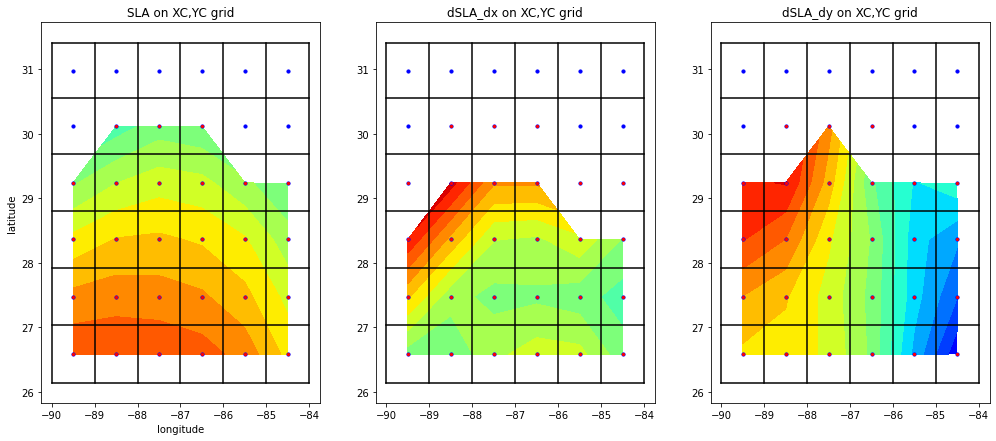

In [82]:
lon_w = -92
lon_e = -84
lat_s = 26
lat_n = 31
tglon = np.where((lons[:,0] > lon_w) & (lons[:,0] < lon_e))[0]
tglat = np.where((lats[0,:] > lat_s) & (lats[0,:] < lat_n))[0]
tglon_g = np.where((lons_g[:,0] >= (lon_w-.5)) & (lons_g[:,0] <= (lon_e+0.5)))[0]
tglat_g = np.where((lats_g[0,:] >= (lat_s-.5)) & (lats_g[0,:] <= (lat_n+0.5)))[0]
print(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0)[tglon,tglat].data.T)
print(lons[tglon,tglat].data.T)
print(lats[tglon,tglat].data.T)
print(s_press.isel(tile=tile_num)[1,tglon,tglat].data.T)
print(deta_dx.isel(tile=tile_num)[1,tglon,tglat].data.T)
print(deta_dy.isel(tile=tile_num)[1,tglon,tglat].data.T)

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,7))
# Kc = ax1.pcolor(lons[tglon,tglat], lats[tglon,tglat], s_press.isel(tile=tile_num)[1,tglon,tglat], cmap='jet', vmin=-2000, vmax=-1000)
Kc = ax1.contourf(lons[tglon,tglat], lats[tglon,tglat], s_press.isel(tile=tile_num)[1,tglon,tglat], np.linspace(-2000,-500, 20,endpoint=True), cmap='jet', vmin=-2000, vmax=-500)
ax1.scatter(lons[tglon,tglat], lats[tglon,tglat], s=10, color='b')
ax1.scatter(ocx, ocy, s=5, color='r')
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g], ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g],'k-')
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g].T, ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g].T,'k-')
ax1.set_title('SLA on XC,YC grid')
ax1.set_xlim([np.nanmin(lons[tglon,tglat])-.75, np.nanmax(lons[tglon,tglat])+.75])
ax1.set_ylim([np.nanmin(lats[tglon,tglat])-.75, np.nanmax(lats[tglon,tglat])+.75])
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')

Kc = ax2.contourf(lons[tglon,tglat], lats[tglon,tglat], deta_dx.isel(tile=tile_num)[1,tglon,tglat], np.linspace(0,2, 20,endpoint=True), cmap='jet', vmin=0, vmax=2)
# Kc = ax2.contourf(lons[tglon,tglat], lats[tglon,tglat], test3[tglon,tglat,1], np.linspace(0,6, 20,endpoint=True), cmap='jet', vmin=0, vmax=6)
ax2.scatter(lons[tglon,tglat], lats[tglon,tglat], s=10, color='b')
ax2.scatter(ocx, ocy, s=5, color='r')
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g], ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g],'k-')
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g].T, ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g].T,'k-')
ax2.set_title('dSLA_dx on XC,YC grid')
ax2.set_xlim([np.nanmin(lons[tglon,tglat])-.75, np.nanmax(lons[tglon,tglat])+.75])
ax2.set_ylim([np.nanmin(lats[tglon,tglat])-.75, np.nanmax(lats[tglon,tglat])+.75])

Kc = ax3.contourf(lons[tglon,tglat], lats[tglon,tglat], deta_dy.isel(tile=tile_num)[1,tglon,tglat], np.linspace(-2,1, 20,endpoint=True), cmap='jet', vmin=-2, vmax=1)
ax3.scatter(lons[tglon,tglat], lats[tglon,tglat], s=10, color='b')
ax3.scatter(ocx, ocy, s=5, color='r')
ax3.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g], ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g],'k-')
ax3.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g].T, ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g].T,'k-')
ax3.set_title('dSLA_dy on XC,YC grid')
ax3.set_xlim([np.nanmin(lons[tglon,tglat])-.75, np.nanmax(lons[tglon,tglat])+.75])
ax3.set_ylim([np.nanmin(lats[tglon,tglat])-.75, np.nanmax(lats[tglon,tglat])+.75])
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_12/gom_edges.jpg', dpi=250)

In [28]:
print(layer_thickness[0,tglon,tglat].data)
print(drho_dx[1,0,tglon,tglat].data)
print(np.round((g*drho_dx[1,:,tglon,tglat]*layer_thickness[:,tglon,tglat]*zz[:,tglon,tglat]).sum(dim='layer').data))
H = (ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF).sum(dim='k')
H = H.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
print((H[tglon,tglat].data))
print((-1/H[tglon,tglat].data)*np.round((g*drho_dx[1,:,tglon,tglat]*layer_thickness[:,tglon,tglat]*zz[:,tglon,tglat]).sum(dim='layer').data))

[[ 0.  0. 10. 10. 10. 10.]
 [ 0. 10. 10. 10. 10. 10.]
 [ 0. 10. 10. 10. 10. 10.]
 [ 0. 10. 10. 10. 10. 10.]
 [ 0.  0. 10. 10. 10. 10.]
 [ 0.  0. 10. 10. 10. 10.]]
[[        nan         nan         nan -0.00288248 -0.00125571 -0.00080487]
 [        nan         nan -0.00247145 -0.00162376 -0.00109743 -0.00097384]
 [        nan         nan -0.00207934 -0.00123644 -0.00113704 -0.00132412]
 [        nan         nan -0.00197294 -0.00111245 -0.00120022 -0.00152467]
 [        nan         nan         nan -0.00111099 -0.00112765 -0.00158912]
 [        nan         nan         nan -0.00130592 -0.00125969 -0.00158945]]
[[  0.   0.   0.   9. 127. 137.]
 [  0.   0.   7.  46. 121. 133.]
 [  0.   0.  13.  46.  91. 140.]
 [  0.   0.  29. 108.  49. 127.]
 [  0.   0.   0.  19.  83.  42.]
 [  0.   0.   0.   9.  28. 100.]]
[[        nan         nan   19.99      728.39514  1817.6925   2731.7634  ]
 [        nan   19.99       95.04     1757.4473   2326.8152   2761.2075  ]
 [        nan   25.        760.441   

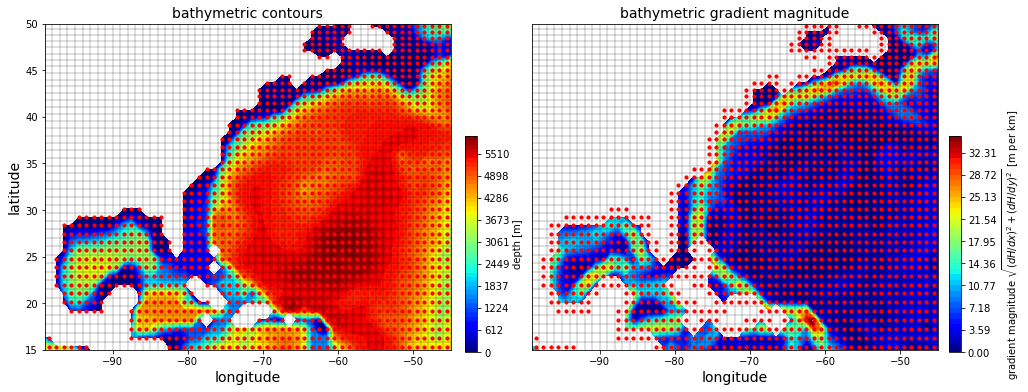

In [35]:
tile_to_plot = dep.isel(tile=tile_num)
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) != 0, np.nan)
f, (ax,ax2) = plt.subplots(1,2,figsize=(16,6))
colMap = plt.get_cmap('jet'); colMap.set_under(color='b'); colMap.set_over(color='r');
cc = ax.contourf(lons, lats, tile_to_plot, np.linspace(0,6000, 50,endpoint=True), cmap=colMap, vmin=0, vmax=6000)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
# ax.scatter(ecco_monthly_ds.XC.isel(tile=tile_num), ecco_monthly_ds.YC.isel(tile=tile_num), color='r', s=1)
ax.scatter(ocx, ocy, s=10, color='r')
ax.set_title('bathymetric contours', fontsize=14)
ax.set_xlabel('longitude', fontsize=14); ax.set_ylabel('latitude', fontsize=14); 
ax.set_xlim(lon_range); ax.set_ylim(lat_range);
cbpos = [0.49, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='depth [m]')

tile_to_plot = gradH
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) != 0, np.nan)
colMap = plt.get_cmap('jet'); colMap.set_under(color='b'); colMap.set_over(color='r');
cc = ax2.contourf(lons, lats, tile_to_plot, np.linspace(0,35, 40,endpoint=True), cmap=colMap, vmin=0, vmax=35)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
# ax.scatter(ecco_monthly_ds.XC.isel(tile=tile_num), ecco_monthly_ds.YC.isel(tile=tile_num), color='r', s=1)
ax2.scatter(ocx, ocy, s=10, color='r')
ax2.set_title('bathymetric gradient magnitude', fontsize=14)
ax2.set_xlabel('longitude', fontsize=14); ax2.set_yticks([]) 
ax2.set_xlim(lon_range); ax2.set_ylim(lat_range);
cbpos = [0.91, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='gradient magnitude $\sqrt{(dH/dx)^2 + (dH/dy)^2}$ [m per km]')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_12/gom_bathy_grad.jpg', dpi=250)

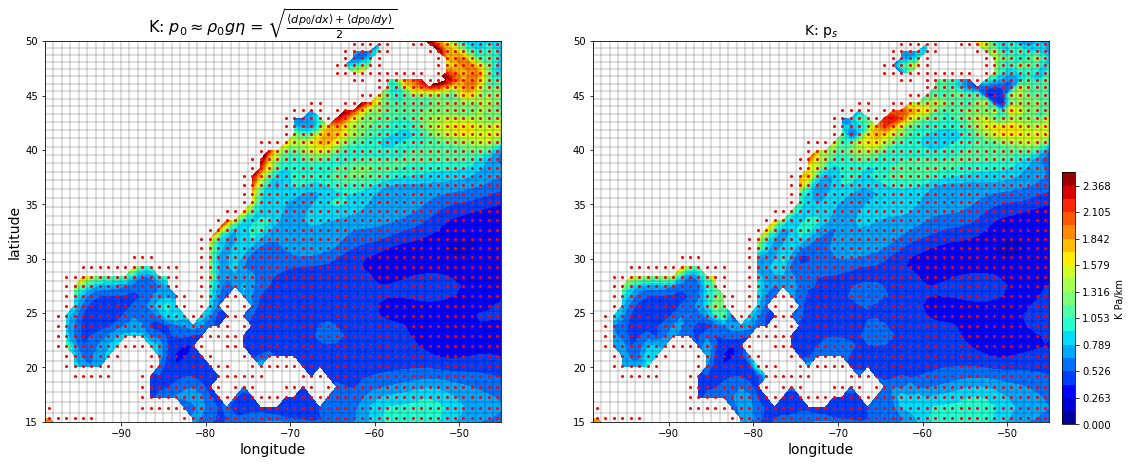

In [36]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(18,7))
maxlim = 2.5
tile_to_plot = K_eta
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
Kc = ax1.contourf(lons, lats, tile_to_plot, np.linspace(0, maxlim, 20,endpoint=True), cmap='jet', vmin=0, vmax=maxlim)
# Kc = ax1.pcolor(lons, lats, tile_to_plot, cmap='jet', vmin=0, vmax=maxlim)
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
ax1.scatter(ocx, ocy, s=4, color='r')
ax1.set_title(r'K: $p_0 \approx \rho_0 g \eta$ = $\sqrt{ \frac{ \langle d p_0 /dx \rangle + \langle d p_0 /dy \rangle}{2}}$', fontsize=16)
ax1.set_xlabel('longitude', fontsize=14)
ax1.set_ylabel('latitude', fontsize=14)
ax1.set_xlim(lon_range); ax1.set_ylim(lat_range);

tile_to_plot = K_ster
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
Kc = ax2.contourf(lons, lats, tile_to_plot, np.linspace(0, maxlim, 20,endpoint=True), cmap='jet', vmin=0, vmax=maxlim)
# Kc = ax2.pcolor(lons, lats, tile_to_plot, cmap='jet', vmin=0, vmax=maxlim)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
ax2.scatter(ocx, ocy, s=4, color='r')
ax2.set_title('K: p$_s$', fontsize=14)
ax2.set_xlabel('longitude', fontsize=14)
ax2.set_xlim(lon_range); ax2.set_ylim(lat_range);

cbpos = [0.91, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='K Pa/km')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_12/gom_K_eta_steric.jpg', dpi=250)

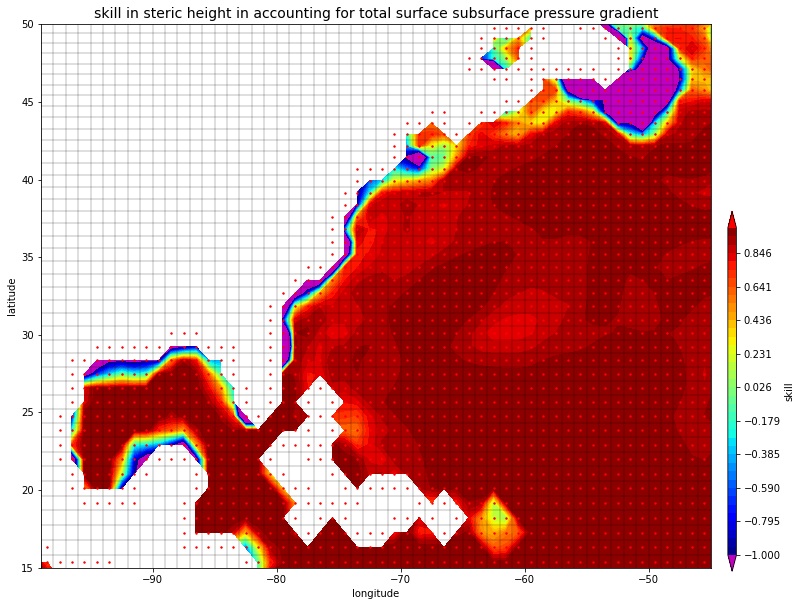

In [41]:
skill = 1 - (((dster_dx.isel(tile=tile_num) - deta_dx.isel(tile=tile_num)).var(dim='time') + \
             (dster_dy.isel(tile=tile_num) - deta_dy.isel(tile=tile_num)).var(dim='time')) / ((dster_dx.isel(tile=tile_num)).var(dim='time') + (dster_dy.isel(tile=tile_num)).var(dim='time')))
f, ax = plt.subplots(1,1,figsize=(12,10))
tile_to_plot = skill
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet'); colMap.set_under(color='m');
Kc = ax.contourf(lons, lats, tile_to_plot, np.linspace(-1, 1, 40,endpoint=True), cmap=colMap, vmin=-1, vmax=1, extend='both')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
ax.scatter(ocx, ocy, s=2, color='r')
ax.set_title('skill in steric height in accounting for total surface subsurface pressure gradient', fontsize=14)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_xlim(lon_range); ax.set_ylim(lat_range);
cbpos = [0.92, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='skill')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_12/gom_K_eta_steric_skill.jpg', dpi=250)

In [667]:
K_eta_minus_ster = np.sqrt(0.5*((deta_dx.isel(tile=tile_num)-dster_dx.isel(tile=tile_num)).var(dim='time') + \
                                (deta_dy.isel(tile=tile_num)-dster_dy.isel(tile=tile_num)).var(dim='time')))
K_eta_minus_ster_minus_topo = np.sqrt(0.5*((deta_dx.isel(tile=tile_num) - dster_dx.isel(tile=tile_num) - topox).var(dim='time') + \
                                (deta_dy.isel(tile=tile_num) - dster_dy.isel(tile=tile_num) - topoy).var(dim='time')))

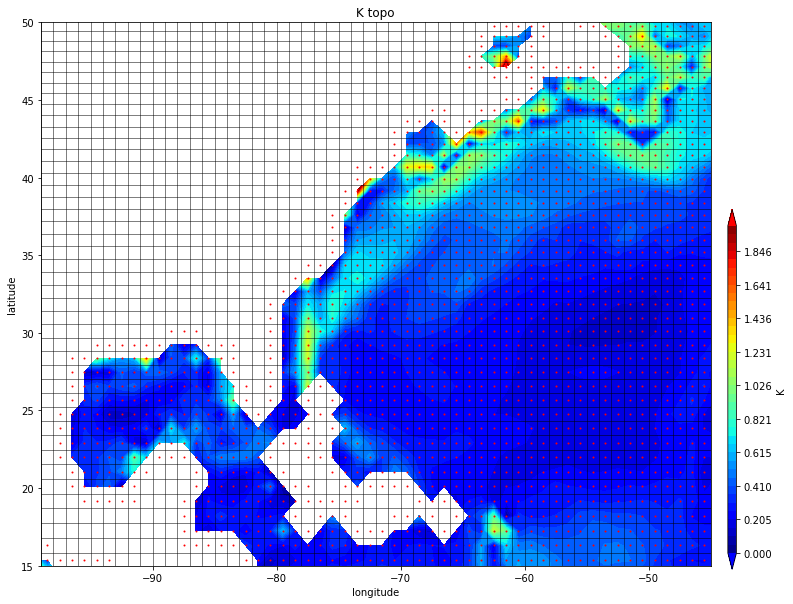

In [113]:
f, ax = plt.subplots(1,1,figsize=(12,10))
tile_to_plot = K_dahpg
cmin = 0
cmax = 2
# tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet'); colMap.set_under(color='b'); colMap.set_over(color='r');
Kc = ax.contourf(lons, lats, tile_to_plot, np.linspace(cmin, cmax, 40,endpoint=True), cmap=colMap, vmin=cmin, vmax=cmax, extend='both')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax.set_title('K topo')
ax.set_xlabel('longitude'); ax.set_ylabel('latitude'); 
ax.scatter(ocx, ocy, s=1, color='r')
ax.set_xlim(lon_range); ax.set_ylim(lat_range);
cbpos = [0.92, 0.12, 0.01, 0.5]; cax = f.add_axes(cbpos);
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='K')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_20/gom_K_topo.jpg', dpi=250)

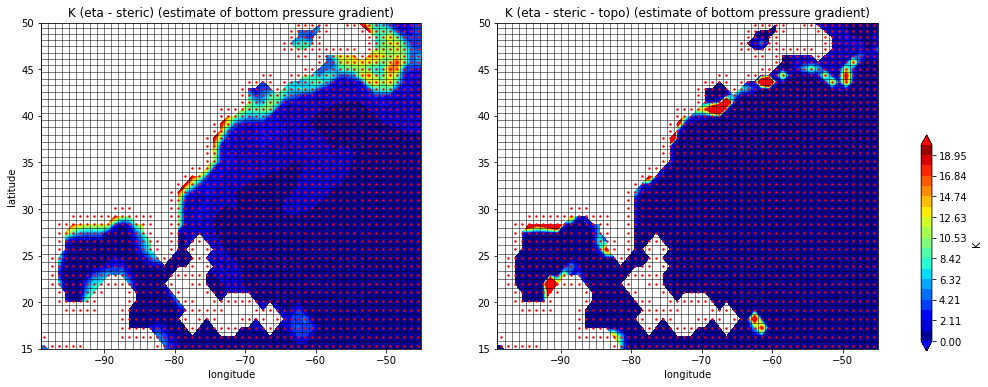

In [669]:
f, (ax,ax2) = plt.subplots(1,2,figsize=(15,6))
maxlim = 3
tile_to_plot = K_eta_minus_ster
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet'); colMap.set_under(color='b'); colMap.set_over(color='r');
Kc = ax.contourf(lons, lats, tile_to_plot, np.linspace(0,maxlim,20), cmap=colMap, vmin=0, vmax=maxlim, extend='both')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax.scatter(ocx, ocy, s=2, color='r')
ax.set_title('K (eta - steric) (estimate of bottom pressure gradient)')
ax.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax.set_xlim(lon_range); ax.set_ylim(lat_range);

maxlim = 20; minlim=0;
tile_to_plot = K_eta_minus_ster_minus_topo; 
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet'); colMap.set_under(color='b');
Kc = ax2.contourf(lons, lats, tile_to_plot, np.linspace(minlim,maxlim,20), cmap=colMap, vmin=minlim, vmax=maxlim, extend='both')
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax2.scatter(ocx, ocy, s=2, color='r')
ax2.set_title('K (eta - steric - topo) (estimate of bottom pressure gradient)')
ax2.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax2.set_xlim(lon_range); ax2.set_ylim(lat_range);
cbpos = [0.94, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='K')

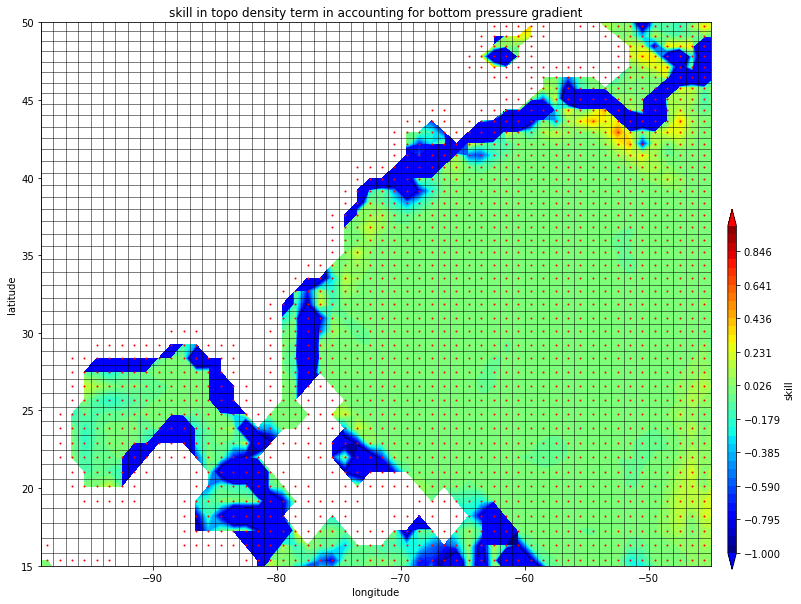

In [670]:
# skill = 1 - (((topox - (deta_dx.isel(tile=tile_num)-dster_dx.isel(tile=tile_num))).var(dim='time') + \
#              (topoy - (deta_dy.isel(tile=tile_num)-dster_dy.isel(tile=tile_num))).var(dim='time')) / ((topox).var(dim='time') + (topoy).var(dim='time')))

skill = 1 - ((((deta_dx.isel(tile=tile_num)-dster_dx.isel(tile=tile_num)) - topox).var(dim='time') + \
             ((deta_dy.isel(tile=tile_num)-dster_dy.isel(tile=tile_num))-topoy).var(dim='time')) / ((deta_dx.isel(tile=tile_num)-dster_dx.isel(tile=tile_num)).var(dim='time') + (deta_dy.isel(tile=tile_num)-dster_dy.isel(tile=tile_num)).var(dim='time')))

f, ax = plt.subplots(1,1,figsize=(12,10))
tile_to_plot = skill
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet')
colMap.set_under(color='b');colMap.set_over(color='r')
Kc = ax.contourf(lons, lats, tile_to_plot, np.linspace(-1, 1, 40,endpoint=True), cmap=colMap, vmin=-1, vmax=1, extend='both')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax.set_title('skill in topo density term in accounting for bottom pressure gradient')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.scatter(ocx, ocy, s=1, color='r')
ax.set_xlim(lon_range); ax.set_ylim(lat_range);
cbpos = [0.92, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='skill')

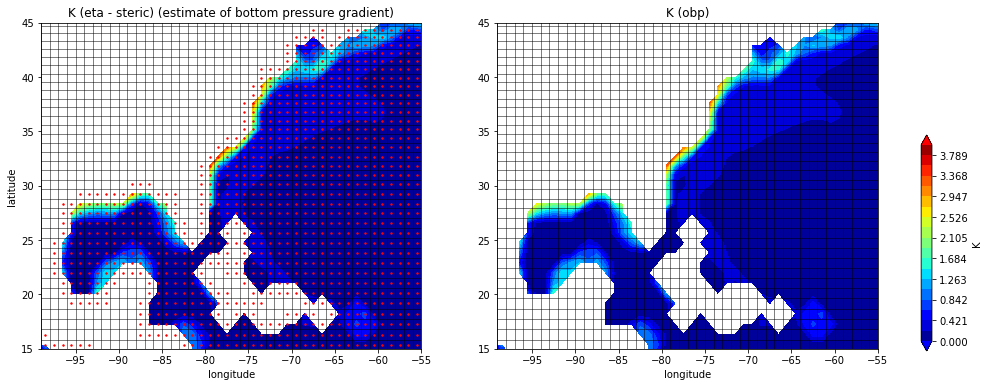

In [465]:
f, (ax,ax2) = plt.subplots(1,2,figsize=(18,7))
maxlim = 4
tile_to_plot = K_eta_minus_ster
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet'); colMap.set_under(color='b'); colMap.set_over(color='r');
Kc = ax.contourf(lons, lats, tile_to_plot, np.linspace(0,maxlim,20), cmap=colMap, vmin=0, vmax=maxlim, extend='both')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax.scatter(ocx, ocy, s=2, color='r')
ax.set_title('K (eta - steric) (estimate of bottom pressure gradient)')
ax.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax.set_xlim(lon_range); ax.set_ylim(lat_range);

tile_to_plot = K_obp; 
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet'); colMap.set_under(color='b');
Kc = ax2.contourf(lons, lats, tile_to_plot, np.linspace(0,maxlim,20), cmap=colMap, vmin=0, vmax=maxlim, extend='both')
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax2.set_title('K (obp)')
ax2.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax2.set_xlim(lon_range); ax2.set_ylim(lat_range);
cbpos = [0.94, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='K')

In [124]:
print(np.where((lons[:,0] > -95) & (lons[:,0] < -93))[0])
print(np.where((lats[0,:] > 25) & (lats[0,:] < 30))[0])
# -- OG -- 36, 70/73
lon_test = 38
lat_test = 73  
# lon_test = 37 # 36,38
# lat_test = 71 # 70
print(lons[lon_test,lat_test].data)
print(lats[lon_test, lat_test].data)

[35 36]
[69 70 71 72 73]
-89.5
25.676054


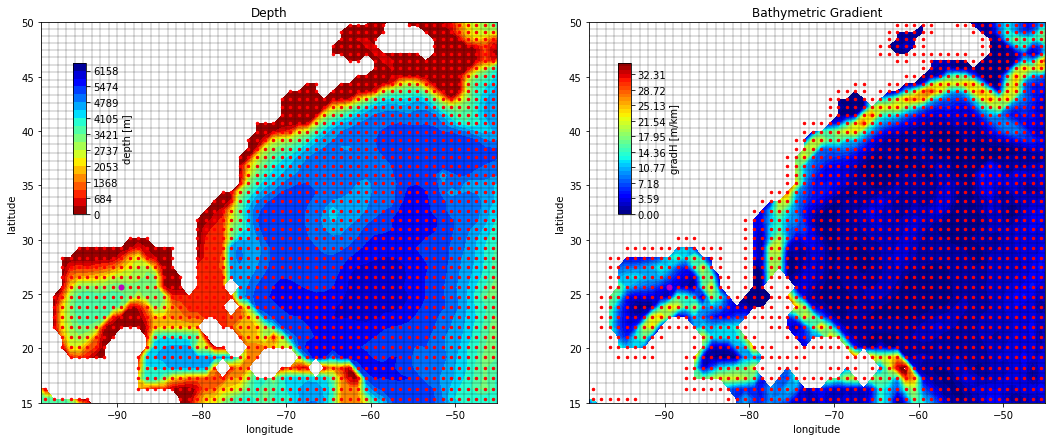

In [125]:
tile_to_plot = dep.isel(tile=tile_num); maxlim=6500 # K_eta; maxlim = 3
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

tile_to_plot2 = gradH # (ecco_monthly_ds.SSHDYN-ecco_monthly_ds.SSHDYN.mean(dim='time')).isel(tile=tile_num)[3]; 
tile_to_plot2= tile_to_plot2.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

f, (ax,ax2) = plt.subplots(1,2,figsize=(18,7))
cc = ax.contourf(lons, lats, tile_to_plot, np.linspace(0,maxlim,20,endpoint=True), cmap='jet_r', vmin=0, vmax=maxlim)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-',linewidth=0.25)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-',linewidth=0.25)
ax.scatter(ocx, ocy, s=6, color='r')
ax.scatter(lons[lon_test,lat_test], lats[lon_test, lat_test], color='m', s=25)
ax.set_title('Depth'); ax.set_xlabel('longitude'); ax.set_ylabel('latitude');
# ax.set_xlim([-101, -65]); ax.set_ylim([15, 36]);
ax.set_xlim(lon_range); ax.set_ylim(lat_range);
cbpos = [0.15, 0.5, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='depth [m]')

cc = ax2.contourf(lons, lats, tile_to_plot2, np.linspace(0,35,40,endpoint=True), cmap='jet', vmin=0, vmax=35) # vmin=-.25, vmax=.25)
# ax2.pcolormesh(lons, lats, tile_to_plot2, cmap='jet', vmin=-2000, vmax=maxlim)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-',linewidth=0.25)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-',linewidth=0.25)
ax2.scatter(ocx, ocy, s=6, color='r')
ax2.scatter(lons[lon_test,lat_test], lats[lon_test, lat_test], color='m', s=25)
ax2.set_title('Bathymetric Gradient'); ax2.set_xlabel('longitude'); ax2.set_ylabel('latitude');
# ax2.set_xlim([-101, -65]); ax2.set_ylim([15, 36]);
ax2.set_xlim(lon_range); ax2.set_ylim(lat_range);
cbpos = [0.57, 0.5, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='gradH [m/km]')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_20/gom_dep_grad_locslope_2.jpg', dpi=250)

[ 2.99108508e-06  2.25149142e-06  1.01783613e-06  4.12228241e-07
  2.87831024e-06  2.22774876e-06  8.13640331e-07 -1.36437934e-06
 -7.39841299e-07 -2.37859538e-06 -2.93944248e-06 -2.69185930e-06
 -2.80396403e-06 -6.82295440e-08 -3.59307979e-07 -5.60936281e-07
 -5.82925510e-07 -1.54813669e-06 -2.73794213e-06 -1.75471874e-06
 -2.76491398e-06 -3.10140648e-06 -2.04555194e-06 -9.14088180e-08
  2.45414630e-07 -3.14993799e-07 -5.16098388e-07 -4.03539472e-07
 -1.56250285e-07  2.71357256e-06  2.01759637e-06  8.72075785e-07
  8.62251478e-08 -5.64898401e-07 -4.52466587e-07  2.10282730e-06
  1.31652892e-06  3.72288255e-08 -9.27677827e-07  1.80720124e-06
  2.23394010e-06  2.66066327e-06  2.54836690e-06  1.40259075e-06
  2.57160467e-07  2.09357905e-06  1.62186425e-06  1.41963522e-06
  1.44160593e-06  9.70575136e-07  4.54608484e-07  2.33581786e-06
  1.95382289e-06  1.66164530e-06  4.26166172e-07 -2.02250389e-06
 -9.94859378e-07 -2.23041354e-06 -2.61253538e-06 -2.23105685e-06
 -1.31094216e-06 -7.94363

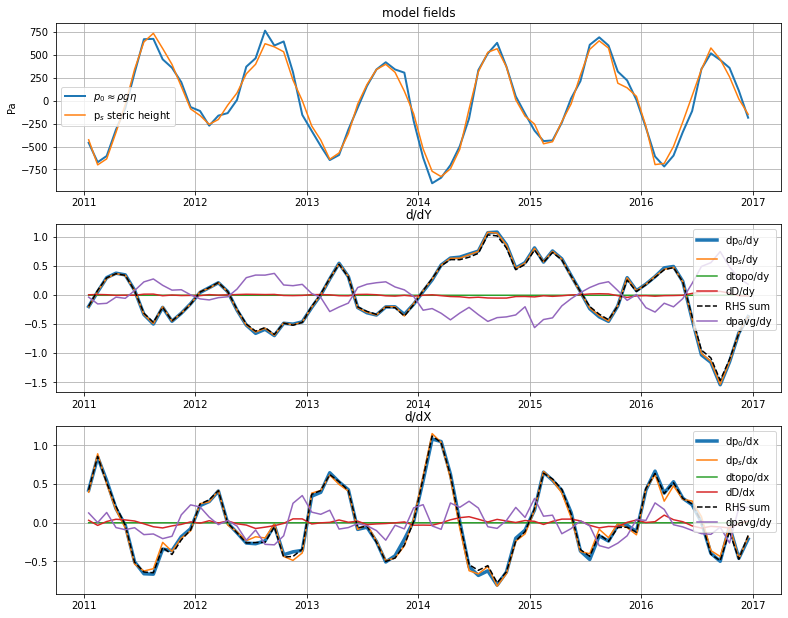

In [126]:
f, (ax,ax2,ax3) = plt.subplots(3,1,figsize=(13,10.5))
# ax.plot(ecco_monthly_ds.time,deta_dx.isel(tile=tile_num)[:, 36, lat_test])
# ax.plot(ecco_monthly_ds.time,dster_dx.isel(tile=tile_num)[:, 36, lat_test])
# ax.plot(ecco_monthly_ds.time,topox[:, 36, lat_test])
# ax.plot(ecco_monthly_ds.time,deta_dy.isel(tile=tile_num)[:, 36, 69])
# ax.plot(ecco_monthly_ds.time,deta_dx.isel(tile=tile_num)[:, 36, 74])
# ax.plot(ecco_monthly_ds.time,deta_dy.isel(tile=tile_num)[:, 36, 74])

ax.plot(ecco_monthly_ds.time,s_press.isel(tile=tile_num)[:, lon_test, lat_test], label=r'$p_0 \approx \rho g \eta$', linewidth=2)
ax.plot(ecco_monthly_ds.time,ster.isel(tile=tile_num)[:, lon_test, lat_test], label=r'p$_s$ steric height')
# ax.plot(ecco_monthly_ds.time,10000*(ds_den.steric-ds_den.steric.mean(dim='time')).isel(tile=tile_num)[:, lon_test, lat_test])
ax.set_title('model fields'); ax.set_ylabel('Pa')
ax.legend(); ax.grid(); 

ax2.plot(ecco_monthly_ds.time,deta_dy.isel(tile=tile_num)[:, lon_test, lat_test], label=r'dp$_0$/dy', linewidth=3.5)
ax2.plot(ecco_monthly_ds.time,dster_dy.isel(tile=tile_num)[:, lon_test, lat_test], label=r'dp$_s$/dy', linewidth=1.5)
ax2.plot(ecco_monthly_ds.time,topoy[:, lon_test, lat_test], label=r'dtopo/dy', linewidth=1.5)
ax2.plot(ecco_monthly_ds.time,a_D_y[lon_test, lat_test, :], label=r'dD/dy', linewidth=1.5)
approx_sum_y = dster_dy.isel(tile=tile_num)[:, lon_test, lat_test] + topoy[:, lon_test, lat_test] + a_D_y[lon_test, lat_test, :]
ax2.plot(ecco_monthly_ds.time,approx_sum_y, color='k', linestyle='--', label='RHS sum')
ax2.plot(ecco_monthly_ds.time,dahpg_y[lon_test, lat_test, :], label=r'dpavg/dy', linewidth=1.5)

test = np.ceil(ecco_grid.hFacC.isel(tile=tile_num).sum(dim='k')) - 1
# ax2.plot(ecco_monthly_ds.time,(rho_a_detrend.isel(layer=test.astype(int)))[:, lon_test, lat_test], label=r'bottom density', linewidth=1.5)
ax2.set_title('d/dY'); ax2.legend(); ax2.grid();
print(rho.isel(layer=test.astype(int))[:,lon_test, lat_test].data)
print(H_y.isel(tile=tile_num)[lon_test, lat_test].data)
print(H_x.isel(tile=tile_num)[lon_test, lat_test].data)

ax3.plot(ecco_monthly_ds.time,deta_dx.isel(tile=tile_num)[:, lon_test, lat_test], label=r'dp$_0$/dx', linewidth=3.5)
ax3.plot(ecco_monthly_ds.time,dster_dx.isel(tile=tile_num)[:, lon_test, lat_test], label=r'dp$_s$/dx', linewidth=1.5)
ax3.plot(ecco_monthly_ds.time,topox[:, lon_test, lat_test], label=r'dtopo/dx', linewidth=1.5)
ax3.plot(ecco_monthly_ds.time,a_D_x[lon_test, lat_test, :], label=r'dD/dx', linewidth=1.5)
approx_sum_x = dster_dx.isel(tile=tile_num)[:, lon_test, lat_test] + topox[:, lon_test, lat_test] + a_D_x[lon_test, lat_test, :]
ax3.plot(ecco_monthly_ds.time,approx_sum_x, color='k', linestyle='--', label='RHS sum')
ax3.plot(ecco_monthly_ds.time,dahpg_x[lon_test, lat_test, :], label=r'dpavg/dy', linewidth=1.5)

# ax3.plot(ecco_monthly_ds.time,dobp_dy.isel(tile=tile_num)[:, lon_test, lat_test], label=r'dobp/dy', linewidth=0.75)
ax3.set_title('d/dX'); ax3.legend(); ax3.grid(); 
# ax2.plot(ecco_monthly_ds.time,dster_dy.isel(tile=tile_num)[:, 36, 74])
# ax2.plot(ecco_monthly_ds.time,dobp_dx.isel(tile=tile_num)[:, 36, 74])
# ax2.plot(ecco_monthly_ds.time,topox[:, 36, 74])
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_20/gom_timeseries_locslope.jpg', dpi=250)

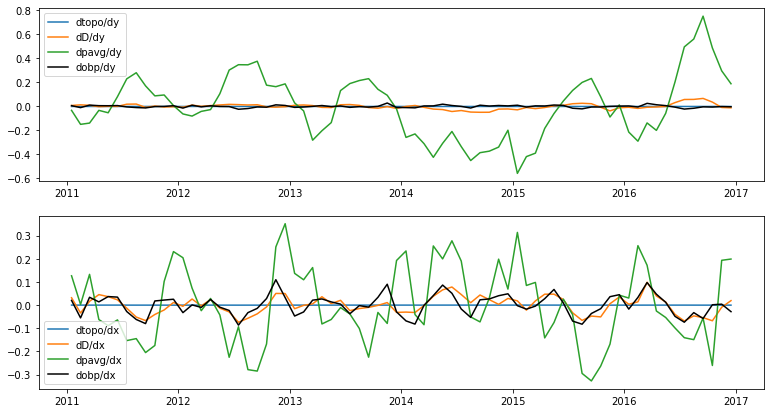

In [127]:
f, (ax,ax2) = plt.subplots(2,1,figsize=(13,7))
ax.plot(ecco_monthly_ds.time,topoy[:, lon_test, lat_test], label=r'dtopo/dy', linewidth=1.5)
ax.plot(ecco_monthly_ds.time,a_D_y[lon_test, lat_test, :], label=r'dD/dy', linewidth=1.5)
ax.plot(ecco_monthly_ds.time,dahpg_y[lon_test, lat_test, :], label=r'dpavg/dy', linewidth=1.5)
ax.plot(ecco_monthly_ds.time,dobp_dy.isel(tile=tile_num)[:,lon_test, lat_test], label=r'dobp/dy', linewidth=1.5, color='k')
ax.legend();

ax2.plot(ecco_monthly_ds.time,topox[:, lon_test, lat_test], label=r'dtopo/dx', linewidth=1.5)
ax2.plot(ecco_monthly_ds.time,a_D_x[lon_test, lat_test, :], label=r'dD/dx', linewidth=1.5)
ax2.plot(ecco_monthly_ds.time,dahpg_x[lon_test, lat_test, :], label=r'dpavg/dx', linewidth=1.5)
ax2.plot(ecco_monthly_ds.time,dobp_dx.isel(tile=tile_num)[:,lon_test, lat_test], label=r'dobp/dx', linewidth=1.5, color='k')
ax2.legend();

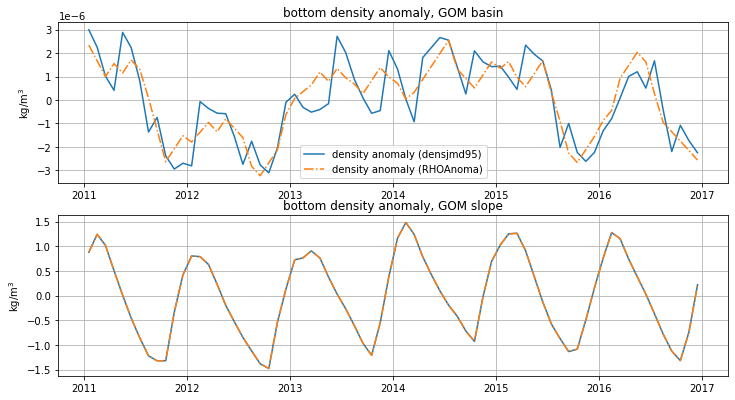

In [271]:
# location 1 (GOM basin)
lon_test = 38 # 36
lat_test = 73 
# location 2 (GOM slope)
lon_test_2 = 36 # 36
lat_test_2 = 70 # 71 
# bottom layer
# test = np.floor(ecco_grid.hFacC.sum(dim='k')).isel(tile=tile_num) - 0
test = np.where(~np.isnan(zz[:,lon_test, lat_test]))[0][-1]
test_2 = np.where(~np.isnan(zz[:,lon_test_2, lat_test_2]))[0][-1]

f, (ax,ax2) = plt.subplots(2,1,figsize=(12,6.5))
# ax.plot(ecco_monthly_ds.time, rho.isel(layer=test.astype(int))[:,lon_test, lat_test].data, label='density anomaly (densjmd95)')
# ax.plot(ecco_monthly_ds.time, rho_2.isel(k=test.astype(int))[:,lon_test, lat_test].data, label='density anomaly (RHOAnoma)', linestyle='-.')
ax.plot(ecco_monthly_ds.time, rho[:,test,lon_test, lat_test].data, label='density anomaly (densjmd95)')
ax.plot(ecco_monthly_ds.time, rho_2[:,test,lon_test, lat_test].data, label='density anomaly (RHOAnoma)', linestyle='-.')
ax.set_title('bottom density anomaly, GOM basin'); ax.legend(); ax.grid(); ax.set_ylabel('kg/m$^3$')

# ax2.plot(ecco_monthly_ds.time, rho_2.isel(k=test.astype(int))[:,lon_test_2, lat_test_2].data)
# ax2.plot(ecco_monthly_ds.time, rho.isel(layer=test.astype(int))[:,lon_test_2, lat_test_2].data, linestyle='-.')
ax2.plot(ecco_monthly_ds.time, rho_2[:,test_2,lon_test_2, lat_test_2].data)
ax2.plot(ecco_monthly_ds.time, rho[:,test_2,lon_test_2, lat_test_2].data, linestyle='-.')
ax2.set_title('bottom density anomaly, GOM slope'); ax2.grid(); ax2.set_ylabel('kg/m$^3$')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_20/gom_timeseries_rho_2.jpg', dpi=250)

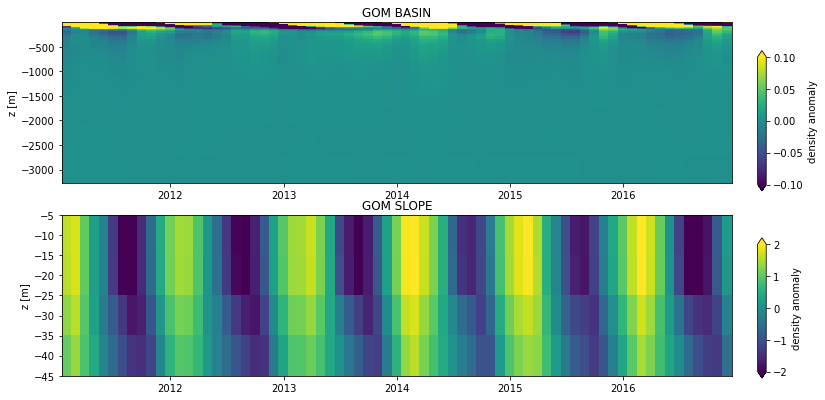

In [274]:
f, (ax,ax2) = plt.subplots(2,1,figsize=(12,6.5))
cc = ax.pcolor(ecco_monthly_ds.time, zz[:,lon_test, lat_test], np.transpose(rho_2[:, :, lon_test, lat_test].data), vmin=-.1, vmax=.1)
ax.set_ylim([np.nanmin(zz[:,lon_test, lat_test]), np.nanmax(zz[:,lon_test, lat_test])]); 
cbpos = [0.93, 0.52, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='density anomaly'); ax.set_title('GOM BASIN'); ax.set_ylabel('z [m]')

cc = ax2.pcolor(ecco_monthly_ds.time, zz[:,lon_test_2, lat_test_2], np.transpose(rho_2[:, :, lon_test_2, lat_test_2].data), vmin=-2, vmax=2)
ax2.set_ylim([np.nanmin(zz[:,lon_test_2, lat_test_2]), np.nanmax(zz[:,lon_test_2, lat_test_2])]); 
cbpos = [0.93, 0.12, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='density anomaly'); ax2.set_title('GOM SLOPE'); ax2.set_ylabel('z [m]')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_20/gom_timeseries_rho_column_2.jpg', dpi=250)

In [154]:
layer_thickness_2 = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF
# layer_thickness_2 = layer_thickness_2.where(layer_thickness_2 != 0, np.nan)
zz_2 = layer_thickness_2.Z
zz_2 = zz_2.where(layer_thickness_2 != 0, np.nan)

rho_0 = ecco_monthly_ds.RHOAnoma.isel(tile=tile_num)
rho_0 = rho_0.where(ecco_monthly_ds.hFacC.isel(tile=tile_num) !=0, np.nan)
rho_a_2 = rho_0 - rho_0.mean(dim='time')
p_2 = rho_a_2.polyfit(dim='time', deg=1)
rho_a_2_trend = xr.polyval(rho_a_2['time'], p_2.polyfit_coefficients)
rho_a_2_detrend = rho_a_2 - rho_a_2_trend
rho_2 = rho_a_2_detrend
rho_2[0,:,lon_test_2,lat_test_2]

<xarray.DataArray (k: 50)>
array([1.61202319, 1.5930949 , 1.32353146, 1.05888233, 0.87892878,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])
Coordinates:
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    j         int64 36
    i         int64 70
    tile      int64 10
    XC        float32 -91.5
    YC        float32 28.36
    CS        float32 -4.037e-15
    SN        float32 -1.0
    Z         (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    Depth     float32 49.04
    rA        float32 9.612e+09
    PHrefC    (k) float32 49.05 147.1 245.2 ... 4.944e+04 5.357e+04 5.794e+04
    drF       (k) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    hFacC     (k) float32 1.0 1.0 1.0 1.0 0.9045 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskC     (k) bool True True True True True ... False False False False
    timestep  int64 167292
    time      datetime64[ns] 2011-01-16T12:00:00

In [114]:
test = ecco_monthly_ds.SALT.isel(tile=tile_num)
test_face = ecco_monthly_ds.hFacC.isel(tile=tile_num)

test_face2 = test_face
test2 = test
test2 = test2.where(test_face2 != 0, np.nan)
# ecco_monthly_ds.RHOAnoma.isel(tile=tile_num)[0, :, lon_test_2, lat_test_2]
# test2[0,:,lon_test_2,lat_test_2]

# test_face2.isel(k=0)
# test2 = test2.where(test_face2.isel(k!=0) != 0, np.nan)
test2[0,:,lon_test_2,lat_test_2]

<xarray.DataArray 'SALT' (k: 50)>
array([36.017876, 36.007717, 36.001244, 35.997192, 35.990875,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan], dtype=float32)
Coordinates:
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    j         int64 36
    i         int64 70
    tile      int64 10
    XC        float32 -91.5
    YC        float32 28.36
    CS        float32 -4.037e-15
    SN        float32 -1.0
    Z         (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    Depth     float32 49.04
    rA        float32 9.612e+09
    PHrefC    (k) float32 49.05 147.1 245.2 ... 4.944e+04 5.357e+04 5.794e+04
    drF       (k) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    hFacC     (k) float32 1.0 1.0 1.0 1.0 0.9045 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskC     (k) bool True True True True True ... False False False False
    timestep  int64 167292
    time      datetime64[ns] 2011-01-16T12:00:00
Attributes:
    units:          psu
    long_name:      Salinity
    standard_name:  sea_water_salinity

In [ ]:
f, ax1 = plt.subplots(1,1,figsize=(8,6))
maxlim = 0.0004
tile_to_plot = K_obp
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
Kc = ax1.contourf(lons, lats, tile_to_plot, np.linspace(0, maxlim, 20,endpoint=True), cmap='jet', vmin=0, vmax=maxlim)
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax1.set_title('K eta')
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_xlim([-99, -70]); ax1.set_ylim([17, 36]);
cbpos = [0.94, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='K')